# Buildings Electricity Meter Consumption Forecasting

---

In this notebook, we are trying to tackle the problem of buildings electricity meter consumption forecasting, and for that, we are going to follow the steps detailed below:
* Step 1: Creation of training and testing datasets,
* Step 2: Build a "naive" model for benchmarking,
* Step 3: Build a forecasting model based on XGBoost,
* Step 4: Build a forecasting model based on LightGBM,
* Step 5: Results summary.

As always, the prerequisite step consists on loading the appropriate packages to perform our work:

In [1]:
# Needed packages:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from utils import create_illustration_sample, create_training_testing_datasets, calculate_rmsle

/Users/mrksinant/Documents/miniconda3/envs/Ashrae/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


---

## Step 1: Creation of training and testing datasets

In this step, we are going to create training and testing datasets and extract a sample to visualize on it the forecasting of the various models we will build below.

In [2]:
# Load the data:
electricity = pd.read_csv("../data/dataset_electricity.csv")

# Check basic info:
print("*** Some basic info:")
print("'dataset_electricity' has {} data points with {} variables each.".format(*electricity.shape))
print("'dataset_electricity' counts {} missing values.".format(electricity.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(electricity.head(n=10))

# Give a look to the last lines:
print("\n*** Last lines:")
display(electricity.tail(n=10))

*** Some basic info:
'dataset_electricity' has 9868987 data points with 39 variables each.
'dataset_electricity' counts 0 missing values.

*** First lines:


,building_id,meter,timestamp,meter_reading,site_id,square_feet,air_temperature,dew_temperature,wind_speed,hour,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,46,0,2016-01-01 00:00:00,53.2397,0,-1.093640,0.831620,1.209052,-1.488506,0,...,0,0,0,0,0,1,0,0,0,0
1,93,0,2016-01-01 00:00:00,52.4206,0,-0.747255,0.831620,1.209052,-1.488506,0,...,1,0,0,0,0,0,0,0,0,0
2,20,0,2016-01-01 01:00:00,91.9886,0,0.347818,0.776153,1.318135,-0.829925,1,...,0,0,0,0,0,0,0,0,0,0
3,46,0,2016-01-01 01:00:00,53.6492,0,-1.093640,0.776153,1.318135,-0.829925,1,...,0,0,0,0,0,1,0,0,0,0
4,46,0,2016-01-01 02:00:00,54.8778,0,-1.093640,0.628242,1.318135,-1.488506,2,...,0,0,0,0,0,1,0,0,0,0
5,46,0,2016-01-01 03:00:00,53.6492,0,-1.093640,0.471087,1.268551,-1.488506,3,...,0,0,0,0,0,1,0,0,0,0
6,96,0,2016-01-01 03:00:00,33.2748,0,1.638818,0.471087,1.268551,-1.488506,3,...,0,0,0,0,0,0,0,0,0,0
7,46,0,2016-01-01 04:00:00,53.6492,0,-1.093640,0.369398,1.209052,-0.346965,4,...,0,0,0,0,0,1,0,0,0,0
8,46,0,2016-01-01 05:00:00,54.4683,0,-1.093640,0.313931,1.149552,-1.488506,5,...,0,0,0,0,0,1,0,0,0,0
9,93,0,2016-01-01 05:00:00,1.4982,0,-0.747255,0.313931,1.149552,-1.488506,5,...,1,0,0,0,0,0,0,0,0,0



*** Last lines:


,building_id,meter,timestamp,meter_reading,site_id,square_feet,air_temperature,dew_temperature,wind_speed,hour,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
9868977,1439,0,2016-02-03 11:00:00,271.450,15,-0.417930,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868978,1440,0,2016-02-03 11:00:00,365.950,15,0.917726,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868979,1441,0,2016-02-03 11:00:00,351.725,15,-0.793207,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868980,1442,0,2016-02-03 11:00:00,116.200,15,0.195010,-1.174425,-0.665192,2.594698,11,...,0,0,0,1,0,0,0,0,0,0
9868981,1443,0,2016-02-03 11:00:00,118.700,15,-0.648416,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868982,1444,0,2016-02-03 11:00:00,4.600,15,-0.943067,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868983,1445,0,2016-02-03 11:00:00,5.550,15,-1.161236,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868984,1446,0,2016-02-03 11:00:00,10.650,15,-1.062027,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868985,1447,0,2016-02-03 11:00:00,205.875,15,-0.798447,-1.174425,-0.665192,2.594698,11,...,0,0,0,0,0,0,0,0,0,0
9868986,1448,0,2016-02-03 11:00:00,3.675,15,0.091487,-1.174425,-0.665192,2.594698,11,...,1,0,0,0,0,0,0,0,0,0


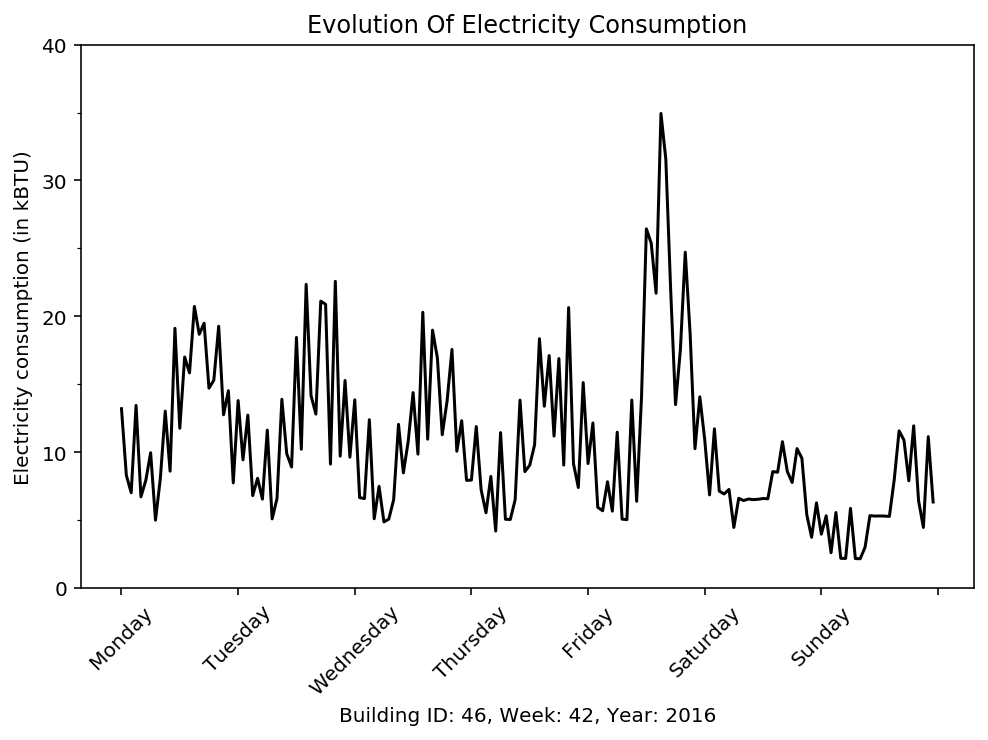

In [3]:
# Create illustration sample we will mobilize latter:
electricity_2, timestamp, y_sample, X_sample = create_illustration_sample(electricity, 46)

# Visualize extracted sample:

# Plotting parameters tuning:
y_sample_val = y_sample.tolist()
weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Definition of the graph:
fig, ax = plt.subplots(figsize=(8, 5))

# Configuration of the graph:
ax.set_title("Evolution Of Electricity Consumption")
ax.plot(timestamp, y_sample_val, color='black', linestyle='solid')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
ax.set_xticklabels(weekday_lst, rotation=45)
ax.set_xlabel('Building ID: 46, Week: 42, Year: 2016')
ax.set_ylim(0, 40)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(8))
ax.set_ylabel('Electricity consumption (in kBTU)')

# Save the graph:
fig.savefig('../graphs/sample_electricity_consumption_target.png', bbox_inches='tight')

In [4]:
# Create training and testing datasets:
X_train, X_test, y_train, y_test = create_training_testing_datasets(electricity_2)

---

## Step 2: Build a "naive" model for benchmarking

For benchmarking the future forecasting models we are going to build, here, we propose a "naive" model: A forecasting prediction model which always predicts the mean value of all meter readings registered in the dataset.

In [5]:
# Determine "naive" model forecasting value:
naive_forecasting = electricity['meter_reading'].mean()
print("The forecasting value for 'naive' model is: {:.2f}.".format(naive_forecasting))

The forecasting value for 'naive' model is: 82.52.


We can now calculate RMSLE error on both training and testing datasets, values which will serve as benchmarks.

In [6]:
# "Naive" model forecasting for training and testing datasets:
y_pred_naive_train = [naive_forecasting]*len(y_train)
y_pred_naive_test = [naive_forecasting]*len(y_test)

# Calculate RMSLE errors:
rmsle_naive_train = calculate_rmsle(y_train, y_pred_naive_train)
rmsle_naive_test = calculate_rmsle(y_test, y_pred_naive_test)

# Print results:
print("*** 'Naive' forecasting model results:")
print("RMSLE on training dataset: {:.6f}".format(rmsle_naive_train))
print("RMSLE on testing dataset: {:.6f}".format(rmsle_naive_test))

*** 'Naive' forecasting model results:
RMSLE on training dataset: 1.426128
RMSLE on testing dataset: 1.425909


To finish this step, we can now use this "naive" model to perform forecasting on the illustration sample.

In [7]:
# "Naive" model forecasting for illustration sample:
y_sample_naive = [naive_forecasting]*len(y_sample)

---

## Step 3: Build a forecasting model based on XGBoost

In this step, we will build an "optimized" forecasting model based on XGBoost.

*Nota Bene:* Due to limited hardware and calculation capacities, we are not able to perform an in-depth optimization of the model, worst, here, we are forced to used the "tuned" hyperparameters obtained during the construction of the buildings hot water meter consumption forecasting XGBoost-based model.

In [8]:
# Define XGBoost-based regressor model:
xgb_reg = xgb.XGBRegressor(n_estimators=77,
                           max_depth=9,
                           learning_rate=0.4,
                           gamma=0.5,
                           reg_alpha=5.,
                           reg_lambda=0.01,
                           random_state=42)

# Train the regressor:
print("Time info about regressor training:")
%time opt_xgb_reg = xgb_reg.fit(X_train, y_train)

Time info about regressor training:
[14:29:24] WARNING: /usr/local/miniconda/conda-bld/xgboost_1584539872846/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 2h 45min 20s, sys: 1h 14min 36s, total: 3h 59min 56s
Wall time: 1h 37min 41s


In [9]:
# "Optimized" XGBoost-based model forecasting for training and testing datasets:
y_pred_xgb_train = opt_xgb_reg.predict(X_train)
y_pred_xgb_test = opt_xgb_reg.predict(X_test)

# Calculate RMSLE errors:
rmsle_xgb_train = calculate_rmsle(y_train, y_pred_xgb_train)
rmsle_xgb_test = calculate_rmsle(y_test, y_pred_xgb_test)

# Print results:
print("*** 'Optimized' XGBoost-based forecasting model results:")
print("RMSLE on training dataset: {:.6f}".format(rmsle_xgb_train))
print("RMSLE on testing dataset: {:.6f}".format(rmsle_xgb_test))

*** 'Optimized' XGBoost-based forecasting model results:
RMSLE on training dataset: 0.739577
RMSLE on testing dataset: 0.742597


We can now use this "optimized" XGBoost-based model to perform forecasting on the illustration sample.

In [10]:
# "Optimized" XGBoost-based model forecasting for illustration sample:
y_sample_xgb = opt_xgb_reg.predict(X_sample).tolist()

To conclude this step, we are going to save the trained model.

In [11]:
# Save model:
joblib.dump(opt_xgb_reg, "../models/opt_xgb_reg_electricity.pkl")

['../models/opt_xgb_reg_electricity.pkl']

---

## Step 4: Build a forecasting model based on LightGBM

In this step, we will build an "optimized" forecasting model based on LightGBM.

*Nota Bene:* Due to limited hardware and calculation capacities, we are not able to perform an in-depth optimization of the model, worst, here, we are forced to used the "tuned" hyperparameters obtained during the construction of the buildings hot water meter consumption forecasting LightGBM-based model.

In [12]:
# Define LightGBM-based regressor model:
lgb_reg = lgb.LGBMRegressor(boosting_type='dart',
                            max_depth=5,
                            learning_rate=1.,
                            n_estimators=100,
                            reg_alpha=0.01,
                            reg_lambda=0.01,
                            random_state=42)

# Train the regressor:
print("Time info about regressor training:")
%time opt_lgb_reg = lgb_reg.fit(X_train, y_train)

Time info about regressor training:
CPU times: user 9min 25s, sys: 6.6 s, total: 9min 32s
Wall time: 2min 44s


In [13]:
# "Optimized" LightGBM-based model forecasting for training and testing datasets:
y_pred_lgb_train = opt_lgb_reg.predict(X_train)
y_pred_lgb_test = opt_lgb_reg.predict(X_test)

# Calculate RMSLE errors:
rmsle_lgb_train = calculate_rmsle(y_train, y_pred_lgb_train)
rmsle_lgb_test = calculate_rmsle(y_test, y_pred_lgb_test)

# Print results:
print("*** 'Optimized' LightGBM-based forecasting model results:")
print("RMSLE on training dataset: {:.6f}".format(rmsle_lgb_train))
print("RMSLE on testing dataset: {:.6f}".format(rmsle_lgb_test))

*** 'Optimized' LightGBM-based forecasting model results:
RMSLE on training dataset: 0.783755
RMSLE on testing dataset: 0.783860


We can now use this "optimized" LightGBM-based model to perform forecasting on the illustration sample.

In [14]:
# "Optimized" LightGBM-based model forecasting for illustration sample:
y_sample_lgb = opt_lgb_reg.predict(X_sample).tolist()

To conclude this step, we are going to save the trained model.

In [15]:
# Save model:
joblib.dump(opt_lgb_reg, "../models/opt_lgb_reg_electricity.pkl")

['../models/opt_lgb_reg_electricity.pkl']

---

## Step 5: Results summary

We can now summarize the results obtained during this notebook:

| Forecasting Model | Training Dataset (RMSLE) | **Testing Dataset (RMSLE)** |
|:-----------------:|:------------------------:|:---------------------------:|
| Naive             | 1.426128                 | 1.425909                    |
| XGBoost           | 0.739577                 | 0.742597                    |
| LightGBM          | 0.783755                 | 0.783860                    |

As and illustration, we can perform forecasting on the sample extracted at the beginning of the notebook, to observe our models in action:

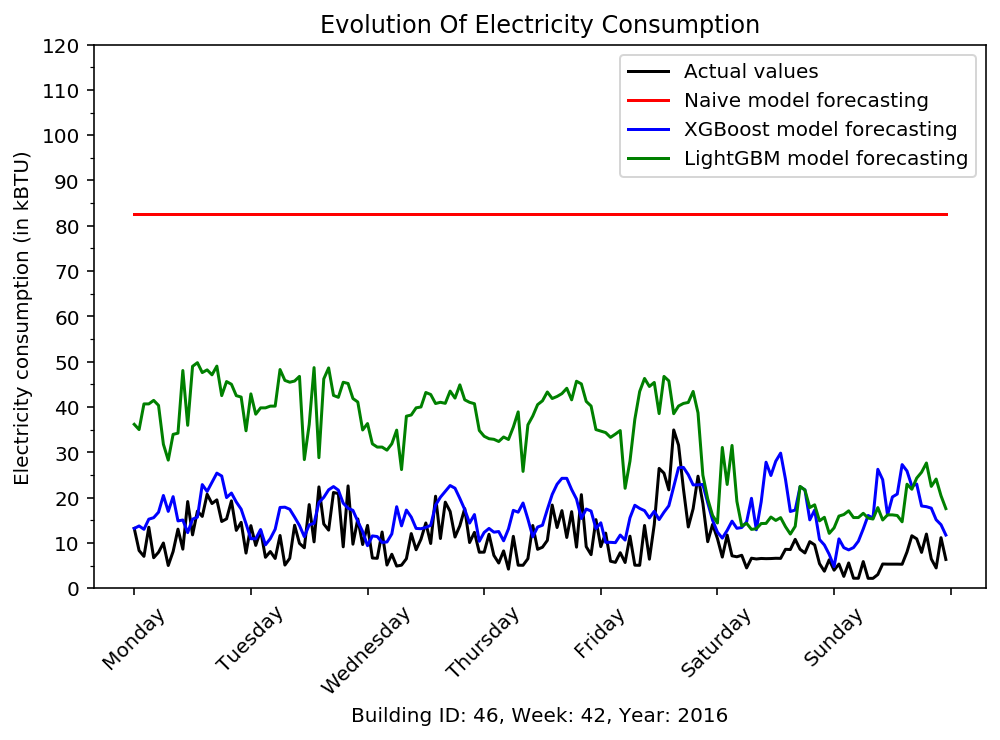

In [16]:
# Definition of the graph:
fig, ax = plt.subplots(figsize=(8, 5))

# Configuration of the graph:
ax.set_title("Evolution Of Electricity Consumption")
ax.plot(timestamp, y_sample_val, color='black', linestyle='solid', label='Actual values')
ax.plot(timestamp, y_sample_naive, color='red', linestyle='solid', label='Naive model forecasting')
ax.plot(timestamp, y_sample_xgb, color='blue', linestyle='solid', label='XGBoost model forecasting')
ax.plot(timestamp, y_sample_lgb, color='green', linestyle='solid', label='LightGBM model forecasting')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
ax.set_xticklabels(weekday_lst, rotation=45)
ax.set_xlabel('Building ID: 46, Week: 42, Year: 2016')
ax.set_ylim(0, 120)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(12))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(24))
ax.set_ylabel('Electricity consumption (in kBTU)')
ax.legend(loc=1)

# Save the graph:
fig.savefig('../graphs/sample_electricity_consumption_comparison.png', bbox_inches='tight')